## Celligner 2: trials

### setting up

In [1]:
from genepy.utils import helper as h

# to comment in your case
from taigapy import TaigaClient
tc = TaigaClient()

from celligner2.dataset import anndata
import pandas as pd
# to comment in your case
from depmapomics import tracker as track

from collections import Counter

#autoreload
%load_ext autoreload
%autoreload 2
#output
from bokeh.plotting import output_notebook
output_notebook()
from anndata import AnnData, read_h5ad

import scanpy as sc
import torch
import matplotlib.pyplot as plt
import numpy as np
import gdown

import celligner2

Loading BokehJS ...

In [2]:
sc.settings.set_figure_params(dpi=500, frameon=False)
sc.set_figure_params(dpi=500)
sc.set_figure_params(figsize=(10, 10))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [ ]:
dataset = read_h5ad("temp/celligner_multi.h5ad")

### some late cleanups

In [70]:
# removing ultra rare samples

In [ ]:
MINEXAMPLE=4

In [ ]:
todrop = []
for k, v in Counter(dataset.obs["disease_type"]).items():
    if v <MINEXAMPLE:
        print(k)
        todrop.append(k)
loc = dataset.obs["disease_type"].isin(todrop)
dataset = AnnData(dataset.X[~loc.values], dataset.obs[~loc], dataset.var)

In [ ]:
todrop = []
for k, v in Counter(dataset.obs["lineage"]).items():
    if v <MINEXAMPLE:
        print(k)
        todrop.append(k)
loc = dataset.obs["lineage"].isin(todrop)
dataset = AnnData(dataset.X[~loc.values], dataset.obs[~loc], dataset.var)

In [ ]:
for val in ['dataset','ends', 'reference', 'method', 'sequencer']:
    print(val, set(dataset.obs[val]))

In [75]:
#TODO: try batch norm use_bn=True, use_ln=False, https://stats.stackexchange.com/questions/474440/why-do-transformers-use-layer-norm-instead-of-batch-norm
#TODO

In [ ]:
dataset.obs.replace({'u':'U', 'other': 'U', '': 'none'}, inplace=True)

In [ ]:
dataset.obs.loc[(dataset.obs['align']=='U') & (dataset.obs['dataset']=='ccle'), 'align'] = 'STAR'
dataset.obs.loc[(dataset.obs['align']=='U') & (dataset.obs['dataset']=='met500'), 'align'] = 'STAR'

In [ ]:
dataset.obs.loc[(dataset.obs['counter']=='U') & (dataset.obs['dataset']=='ccle'), 'counter'] = 'RSEM'
dataset.obs.loc[(dataset.obs['counter']=='U') & (dataset.obs['dataset']=='met500'), 'counter'] = 'RSEM'

we can use estimation for the missing values in the conditional dataset

In [ ]:
dataset.obs.loc[(dataset.obs['cell_format']=='U') & dataset.obs['dataset'].isin(['hcmi','cclf']), "cell_format"] = ["2D","3D","3D","3D","3D"]# = evaluator.adata_latent.obs.loc[dataset.obs.loc[(dataset.obs['cell_format']=='U')].index, 'cell_format_pred']

In [ ]:
print(set(dataset.obs.loc[(dataset.obs['cell_format']=='U')].dataset))
dataset.obs['cell_format'] = dataset.obs['cell_format'].cat.rename_categories({'U':'none'})

In [ ]:
print(set(dataset.obs.loc[(dataset.obs['conservation']=='U')].dataset))
dataset.obs['conservation'] = dataset.obs['conservation'].cat.rename_categories({'U':'none'})

In [82]:
dataset.obs.loc[dataset.obs.sample_type=='model', 'contamination'] = 'none'

In [83]:
dataset.obs.morphology = dataset.obs.morphology.cat.add_categories('none')
dataset.obs.loc[dataset.obs.sample_type!='model', 'morphology'] = 'none'

In [85]:
low_nan_genes = np.isnan(dataset.X).sum(0)<len(dataset.X)*0.01
loc1 = np.argsort(np.nanvar(dataset.X[:,low_nan_genes], 0))[-3000:]
loc2 = np.argsort(np.nanvar(dataset.X, 0))[-3000:]
loc3 = np.argsort(np.nanvar(dataset[dataset.obs.dataset.isin(['ccle', 'tcga'])].X, 0))[-3000:]
no_nan_genes = np.isnan(dataset.X).sum(0)==0
loc4 = np.argsort(np.var(dataset.X[:,no_nan_genes], 0))[-3000:]
loc5 = np.argsort(np.var(dataset[dataset.obs.dataset.isin(['ccle', 'tcga'])].X[:,no_nan_genes], 0))[-3000:]

In [67]:
len(set(dataset.var[no_nan_genes].iloc[loc4].index) & set(dataset.var.iloc[loc3].index))

2575

In [63]:
len(set(dataset.var[low_nan_genes].iloc[loc1].index) & set(dataset.var.iloc[loc3].index))

2577

In [64]:
len(set(dataset.var[low_nan_genes].iloc[loc1].index) & set(dataset.var.iloc[loc2].index))

2502

In [84]:
len(set(dataset.var[no_nan_genes].iloc[loc4].index) & set(dataset.var[low_nan_genes].iloc[loc1].index))

2997

In [86]:
len(set(dataset.var[no_nan_genes].iloc[loc4].index) & set(dataset.var[no_nan_genes].iloc[loc5].index))

2936

In [87]:
low_nan_genes = np.isnan(dataset.X).sum(0)<len(dataset.X)*0.01
loc = np.argsort(np.nanvar(dataset.X[:,low_nan_genes], 0))[-3000:]
dataset = AnnData(dataset.X[:,low_nan_genes][:,loc], dataset.obs, dataset.var[low_nan_genes].iloc[loc])

In [20]:
(np.isnan(dataset.X).sum(0)).sum()

435

In [22]:
dataset.X.var(0)

array([ 2.2040436,  2.2042031,  2.2044477, ..., 16.079039 , 16.184084 ,
       18.779043 ], dtype=float32)

In [21]:
cols = ['dataset', 'sample_type', 'cell_format',]#,'reference','sequencer', 'sample_type', 'align', 'counter', 'conservation', 'cell_format']

In [22]:
pred = ['lineage', 'age', "sex"]#,'disease_type']#, 'doublingt' , 'cell_type', 'morphology', 'instability', 'hasebv', 'stage']#,'contamination']

## learning on hcmi and met500 with leiden clust 

In [63]:
dataset.obs.columns

Index(['collection_site', 'disease_type', 'doublingt', 'method', 'reference',
       'age', 'cell_type', 'ends', 'sequencer', 'participant_id', 'sex',
       'base_media', 'morphology', 'dataset', 'ethnicity', 'instability',
       'hasebv', 'tissue_id', 'sample_type', 'align', 'counter',
       'passage_number', 'contamination', 'lineage', 'stage', 'conservation',
       'cell_format'],
      dtype='object')

In [35]:
dataset.write('temp/cleanup_multi.h5ad.gz', compression='gzip')

In [3]:
dataset = read_h5ad("temp/cleanup_multi.h5ad.gz")

In [90]:
prev_dataset = read_h5ad("temp/celligner_multi.h5ad.gz")

In [107]:
prev_dataset
loc = np.argsort(prev_dataset.X.var(0))[-3000:]
prev_tosend = AnnData(prev_dataset.X[:,loc], prev_dataset.obs, prev_dataset.var.iloc[loc])

In [20]:
tosend = dataset[~dataset.obs.dataset.isin(['pediatric_PDX', 'hcmi', 'met500', 'cclf'])]

In [117]:
tosend = dataset.copy()
tosend = tosend[~tosend.obs.dataset.isin(['pediatric_PDX', 'hcmi', 'met500', 'cclf'])]
cl2n = celligner2.CELLIGNER2(
    adata=tosend,
    condition_keys=cols,
    predictor_keys=['lineage', 'age', "sex"],
    hidden_layer_sizes=[256, 128],
    classifier_hidden_layer_sizes=[32, 64],
    use_mmd = True,
    latent_dim=16,
    beta=500,
    betaclass=0.8,
    apply_log=False,
    #mmd_on='y1'
    #recon_loss="mse",
)
cl2n.train(
    n_epochs=300,
    alpha_epoch_anneal=200,
    cell_type_key='lineage',
    early_stopping_kwargs= {
        "early_stopping_metric": "val_unweighted_loss",
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    alpha_kl=0.001,
    train_frac=0.75,
    batch_size=100,
    #monitor_only_val=False,
    n_workers=12,
    min_weight=0.000001,
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3000 256 2
	Hidden Layer 1 in/out: 256 128
	Mean/Var Layer in/out: 128 16
Classifier Architecture:
	First Layer in/out:  16 32
	Hidden Layer 1 in/out: 32 64
	Output Layer in/out:  64 39 

Decoder Architecture:
	First Layer in, out and cond:  16 128 2
	Hidden Layer 1 in/out: 128 256
	Output Layer in/out:  256 3000 



Trying to set attribute `.obs` of view, copying.


Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1


/home/jeremie/celligner2/celligner2/dataset/celligner2/anndata.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.goodloc = torch.tensor(goodloc, dtype=torch.bool)


 |█████---------------| 26.7%  - val_loss: 4935.5395869502 - val_recon_loss: 4511.6836118345 - val_kl_loss: 65.8714384856 - val_class_ce_loss: 97.1710935522 - val_mmd_loss: 326.65888468429
ADJUSTED LR
 |██████--------------| 34.3%  - val_loss: 4880.4057798032 - val_recon_loss: 4489.9774667245 - val_kl_loss: 65.8494234438 - val_class_ce_loss: 90.8718614931 - val_mmd_loss: 299.5228237576
ADJUSTED LR
 |███████-------------| 36.7%  - val_loss: 4912.0102719907 - val_recon_loss: 4486.2255497685 - val_kl_loss: 65.8496582596 - val_class_ce_loss: 91.1170106111 - val_mmd_loss: 334.6319534867
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 88


tential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 |███-----------------| 18.0%  - val_loss: 8799.0014648438 - val_recon_loss: 5521.0173068576 - val_kl_loss: 65.7575039334 - val_class_ce_loss: 1196.2940425166 - val_mmd_loss: 2081.6724712231
ADJUSTED LR
 |████----------------| 20.3%  - val_loss: 9149.5041775174 - val_recon_loss: 5515.7696397569 - val_kl_loss: 65.7672825566 - val_class_ce_loss: 1195.6772664388 - val_mmd_loss: 2438.0377027724
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 39

In [18]:
from celligner2 import plotting as pl

In [118]:
evaluator = pl.CELLIGNER2_EVAL(cl2n)

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'lineage_pred' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'age_pred' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed

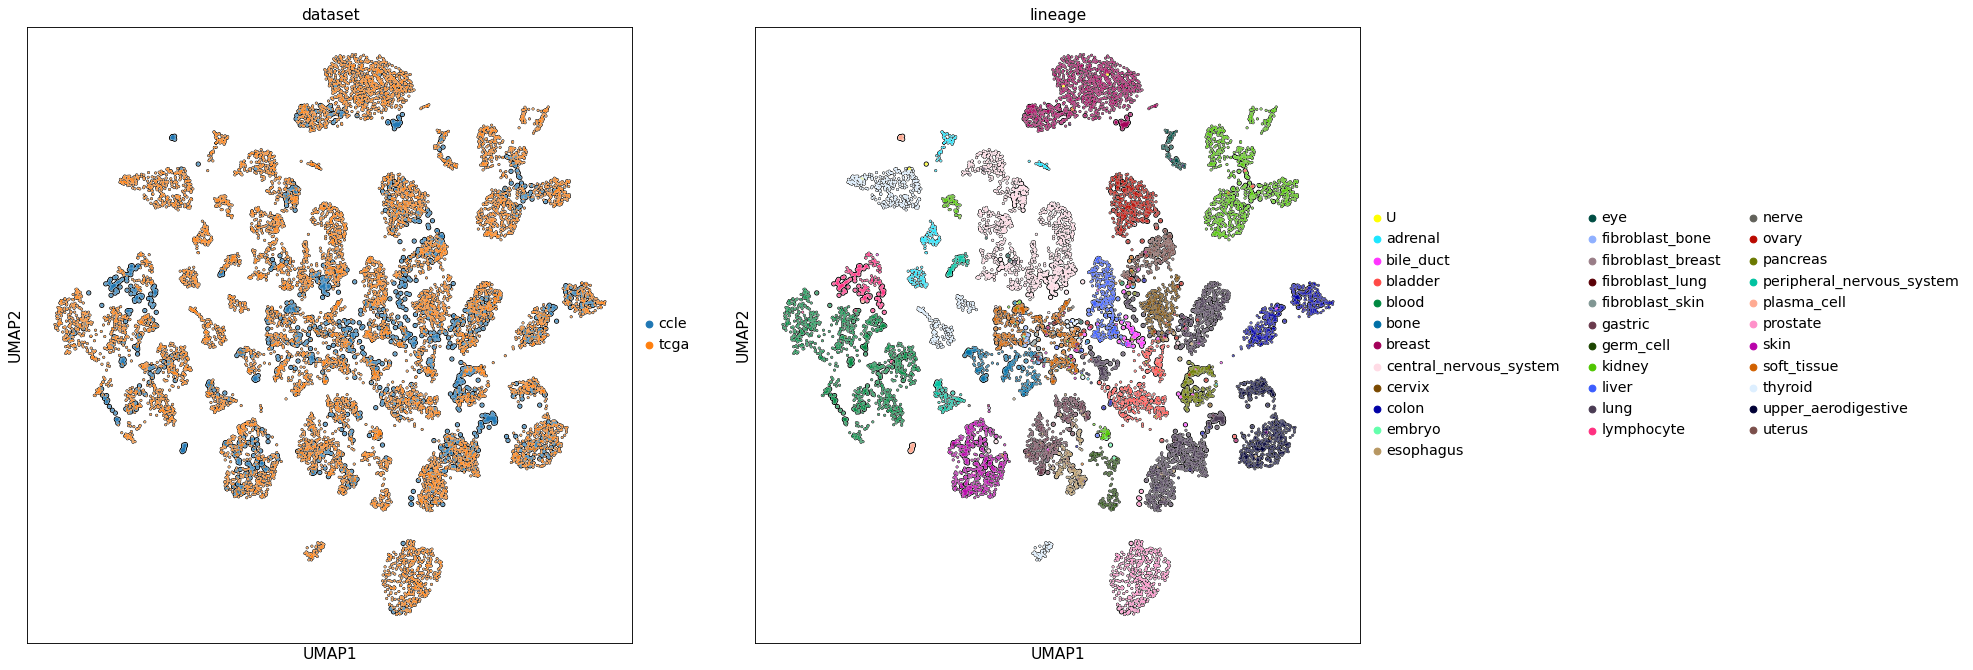

In [119]:
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=.5,
                            alpha=1,
                            spread=1,
                            random_state=None),
                    color=['dataset','lineage'],
                    projection="2d",
                    n_neighbors = 8,
                    rerun=True,
                    add_outline = True,
                    size = [30 if val != 'tcga' else 10 for val in evaluator.adata_latent.obs['dataset']])

In [142]:
cl2n.save("temp/subdataset_learning_target", overwrite=True)

In [40]:
evaluator.adata_latent.obs[pred] = dataset.obs[pred]

In [15]:
cl2 = celligner2.CELLIGNER2.load_query_data(adata=dataset[dataset.obs.dataset.isin(['hcmi', 'met500', 'cclf'])].copy(), reference_model='temp/subdataset_learning_target')

AnnData object with n_obs × n_vars = 1141 × 3000
    obs: 'collection_site', 'disease_type', 'doublingt', 'method', 'reference', 'age', 'cell_type', 'ends', 'sequencer', 'participant_id', 'sex', 'base_media', 'morphology', 'dataset', 'ethnicity', 'instability', 'hasebv', 'tissue_id', 'sample_type', 'align', 'counter', 'passage_number', 'contamination', 'lineage', 'stage', 'conservation', 'cell_format'
dict_keys(['apply_log_', 'beta_', 'betaclass_', 'classifier_hidden_layer_sizes_', 'condition_keys_', 'conditions_', 'dr_rate_', 'hidden_layer_sizes_', 'input_dim_', 'is_trained_', 'latent_dim_', 'miss_', 'mmd_boundary_', 'mmd_on_', 'predictor_keys_', 'predictors_', 'recon_loss_', 'use_bn_', 'use_ln_', 'use_mmd_', 'use_own_kl_'])
> /home/jeremie/celligner2/celligner2/othermodels/base/_base.py(266)load_query_data()
    264 
    265                 pdb.set_trace()
--> 266                 if len(new) > 0:
    267                     print("Adding new conditions: ", new)
    268               

In [16]:
cl2.train(
    n_epochs=300,
    alpha_epoch_anneal=200,
    early_stopping_kwargs={
        "early_stopping_metric": "val_unweighted_loss",
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    weight_decay=0
)

using leiden clustering to define training group mixing


         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
/home/jeremie/celligner2/celligner2/dataset/celligner2/anndata.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.goodloc = torch.tensor(goodloc, dtype=torch.bool)


Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
 |████████------------| 40.7%  - val_loss: 6397.3243815104 - val_recon_loss: 4888.5161132812 - val_kl_loss: 65.8318252563 - val_class_ce_loss: 189.6838480632 - val_mmd_loss: 1319.0844726562
ADJUSTED LR
 |██████████----------| 50.0%  - val_loss: 6394.7420247396 - val_recon_loss: 4889.6235351562 - val_kl_loss: 65.8328857422 - val_class_ce_loss: 185.9765192668 - val_mmd_loss: 1319.0930582682
ADJUSTED LR
 |██████████----------| 52.3%  - val_loss: 6382.3631184896 - val_recon_loss: 4894.4920247396 - val_kl_loss: 65.8312606812 - val_class_ce_loss: 185.7355957031 - val_mmd_loss: 1302.0842692057
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping cr

In [34]:
sub = dataset[dataset.obs.dataset.isin(['hcmi', 'met500', 'cclf'])]

In [41]:
cl2.predictor_set_ = {
                    key: set(tosend.obs[key]) - set(cl2.miss_) for key in cl2.predictor_keys_
                }

In [38]:
cl2.predictor_set_

{'lineage': {'adrenal',
  'ampulla of vater',
  'bile_duct',
  'bladder',
  'blood',
  'bone',
  'brain',
  'breast',
  'central_nervous_system',
  'cervix',
  'colon',
  'embryo',
  'esophagus',
  'eye',
  'fibroblast_bone',
  'fibroblast_breast',
  'fibroblast_lung',
  'fibroblast_skin',
  'gall_bladder',
  'gastric',
  'germ_cell',
  'kidney',
  'liver',
  'lung',
  'lymphocyte',
  'nerve',
  'oral',
  'ovary',
  'pancreas',
  'peripheral_nervous_system',
  'plasma_cell',
  'prostate',
  'skin',
  'soft_tissue',
  'stomach',
  'testis',
  'thyroid',
  'upper_aerodigestive',
  'uterus'},
 'age': {'Adult', 'Children', 'Embryo', 'Pediatric'},
 'sex': {'female', 'male'}}

In [32]:
tosend

View of AnnData object with n_obs × n_vars = 13551 × 3000
    obs: 'collection_site', 'disease_type', 'doublingt', 'method', 'reference', 'age', 'cell_type', 'ends', 'sequencer', 'participant_id', 'sex', 'base_media', 'morphology', 'dataset', 'ethnicity', 'instability', 'hasebv', 'tissue_id', 'sample_type', 'align', 'counter', 'passage_number', 'contamination', 'lineage', 'stage', 'conservation', 'cell_format'

In [40]:
cl2.model.predictor_encoder

{'bile_duct': 0,
 'fibroblast_lung': 1,
 'bladder': 2,
 'thyroid': 3,
 'Adult': 4,
 'fibroblast_skin': 5,
 'pancreas': 6,
 'germ_cell': 7,
 'breast': 8,
 'female': 9,
 'bone': 10,
 'colon': 11,
 'eye': 12,
 'peripheral_nervous_system': 13,
 'lung': 14,
 'gastric': 15,
 'prostate': 16,
 'lymphocyte': 17,
 'uterus': 18,
 'skin': 19,
 'central_nervous_system': 20,
 'plasma_cell': 21,
 'soft_tissue': 22,
 'Embryo': 23,
 'upper_aerodigestive': 24,
 'adrenal': 25,
 'esophagus': 26,
 'embryo': 27,
 'liver': 28,
 'cervix': 29,
 'Pediatric': 30,
 'kidney': 31,
 'male': 32,
 'fibroblast_breast': 33,
 'Children': 34,
 'nerve': 35,
 'blood': 36,
 'ovary': 37,
 'fibroblast_bone': 38}

In [42]:
evaluator = pl.CELLIGNER2_EVAL(cl2)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [139]:
evaluator.get_class_quality(classes=pred, )#only=['hcmi', 'met500'], on="dataset")

lineage
all predicted categories:  {'bile_duct', 'thyroid', 'bladder', 'fibroblast_skin', 'pancreas', 'germ_cell', 'breast', 'bone', 'colon', 'peripheral_nervous_system', 'lung', 'gastric', 'prostate', 'uterus', 'lymphocyte', 'skin', 'central_nervous_system', 'soft_tissue', 'upper_aerodigestive', 'adrenal', 'ovary', 'esophagus', 'liver', 'cervix', 'kidney', 'fibroblast_breast', 'nerve', 'blood', 'fibroblast_lung'}
accuracy:  0.5594111461619348
F1 Score (weigthed): 0.54
F1 Score (macro): 0.28


age
all predicted categories:  {'Children', 'Pediatric', 'Adult'}
accuracy:  0.9266666666666666
F1 Score (weigthed): 0.91
F1 Score (macro): 0.55


sex
all predicted categories:  {'female', 'male'}
accuracy:  0.8146718146718147
F1 Score (weigthed): 0.82
F1 Score (macro): 0.81


disease_type


KeyError: 'disease_type'

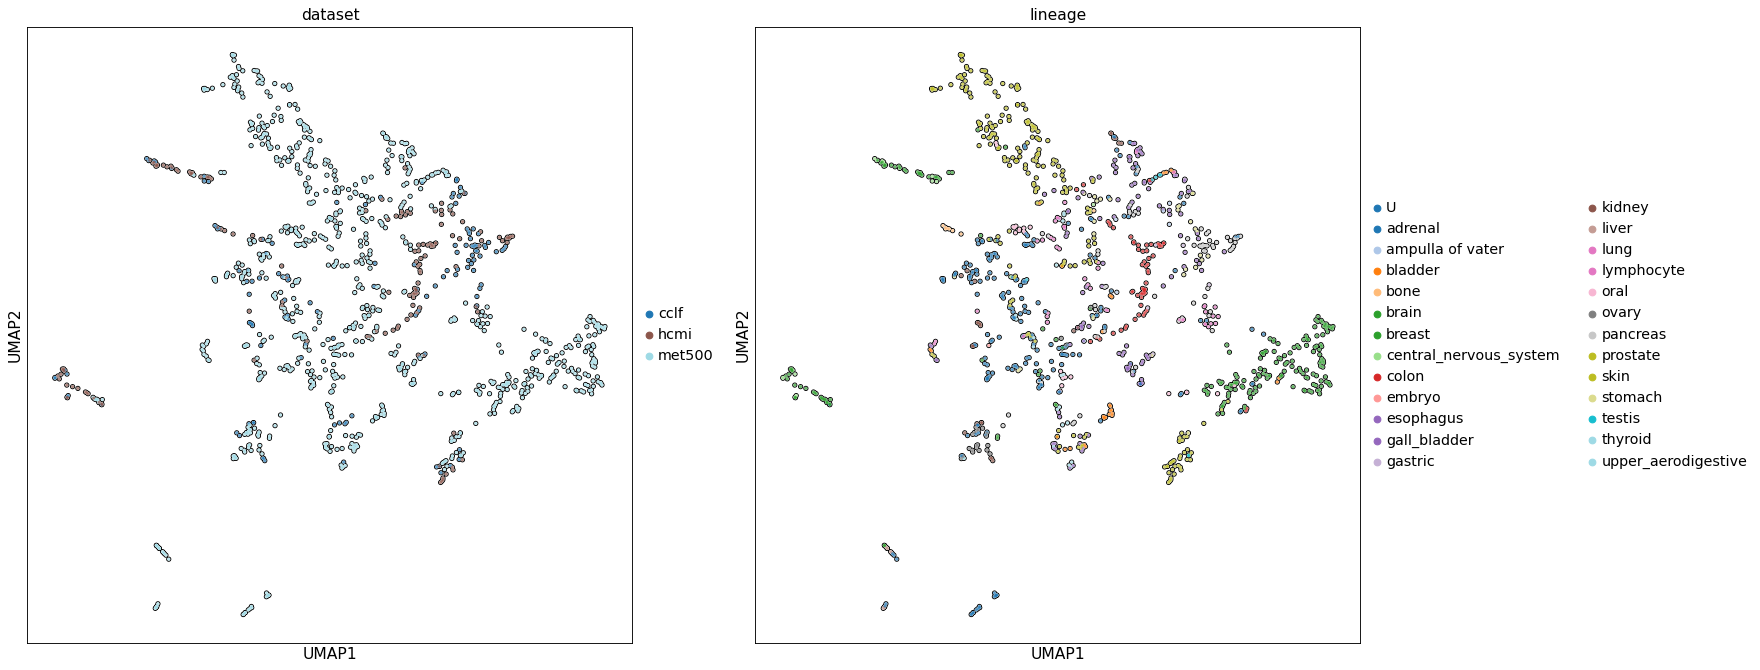

In [146]:
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=.3,
                            alpha=1,
                            spread=1,
                            random_state=None),
                    color=['dataset','lineage'],
                    projection="2d",
                    n_neighbors = 5,
                    rerun=False,
                    palette='tab20',
                    add_outline = True,
                    size = [30 if val != 'tcga' else 10 for val in evaluator.adata_latent.obs['dataset']])

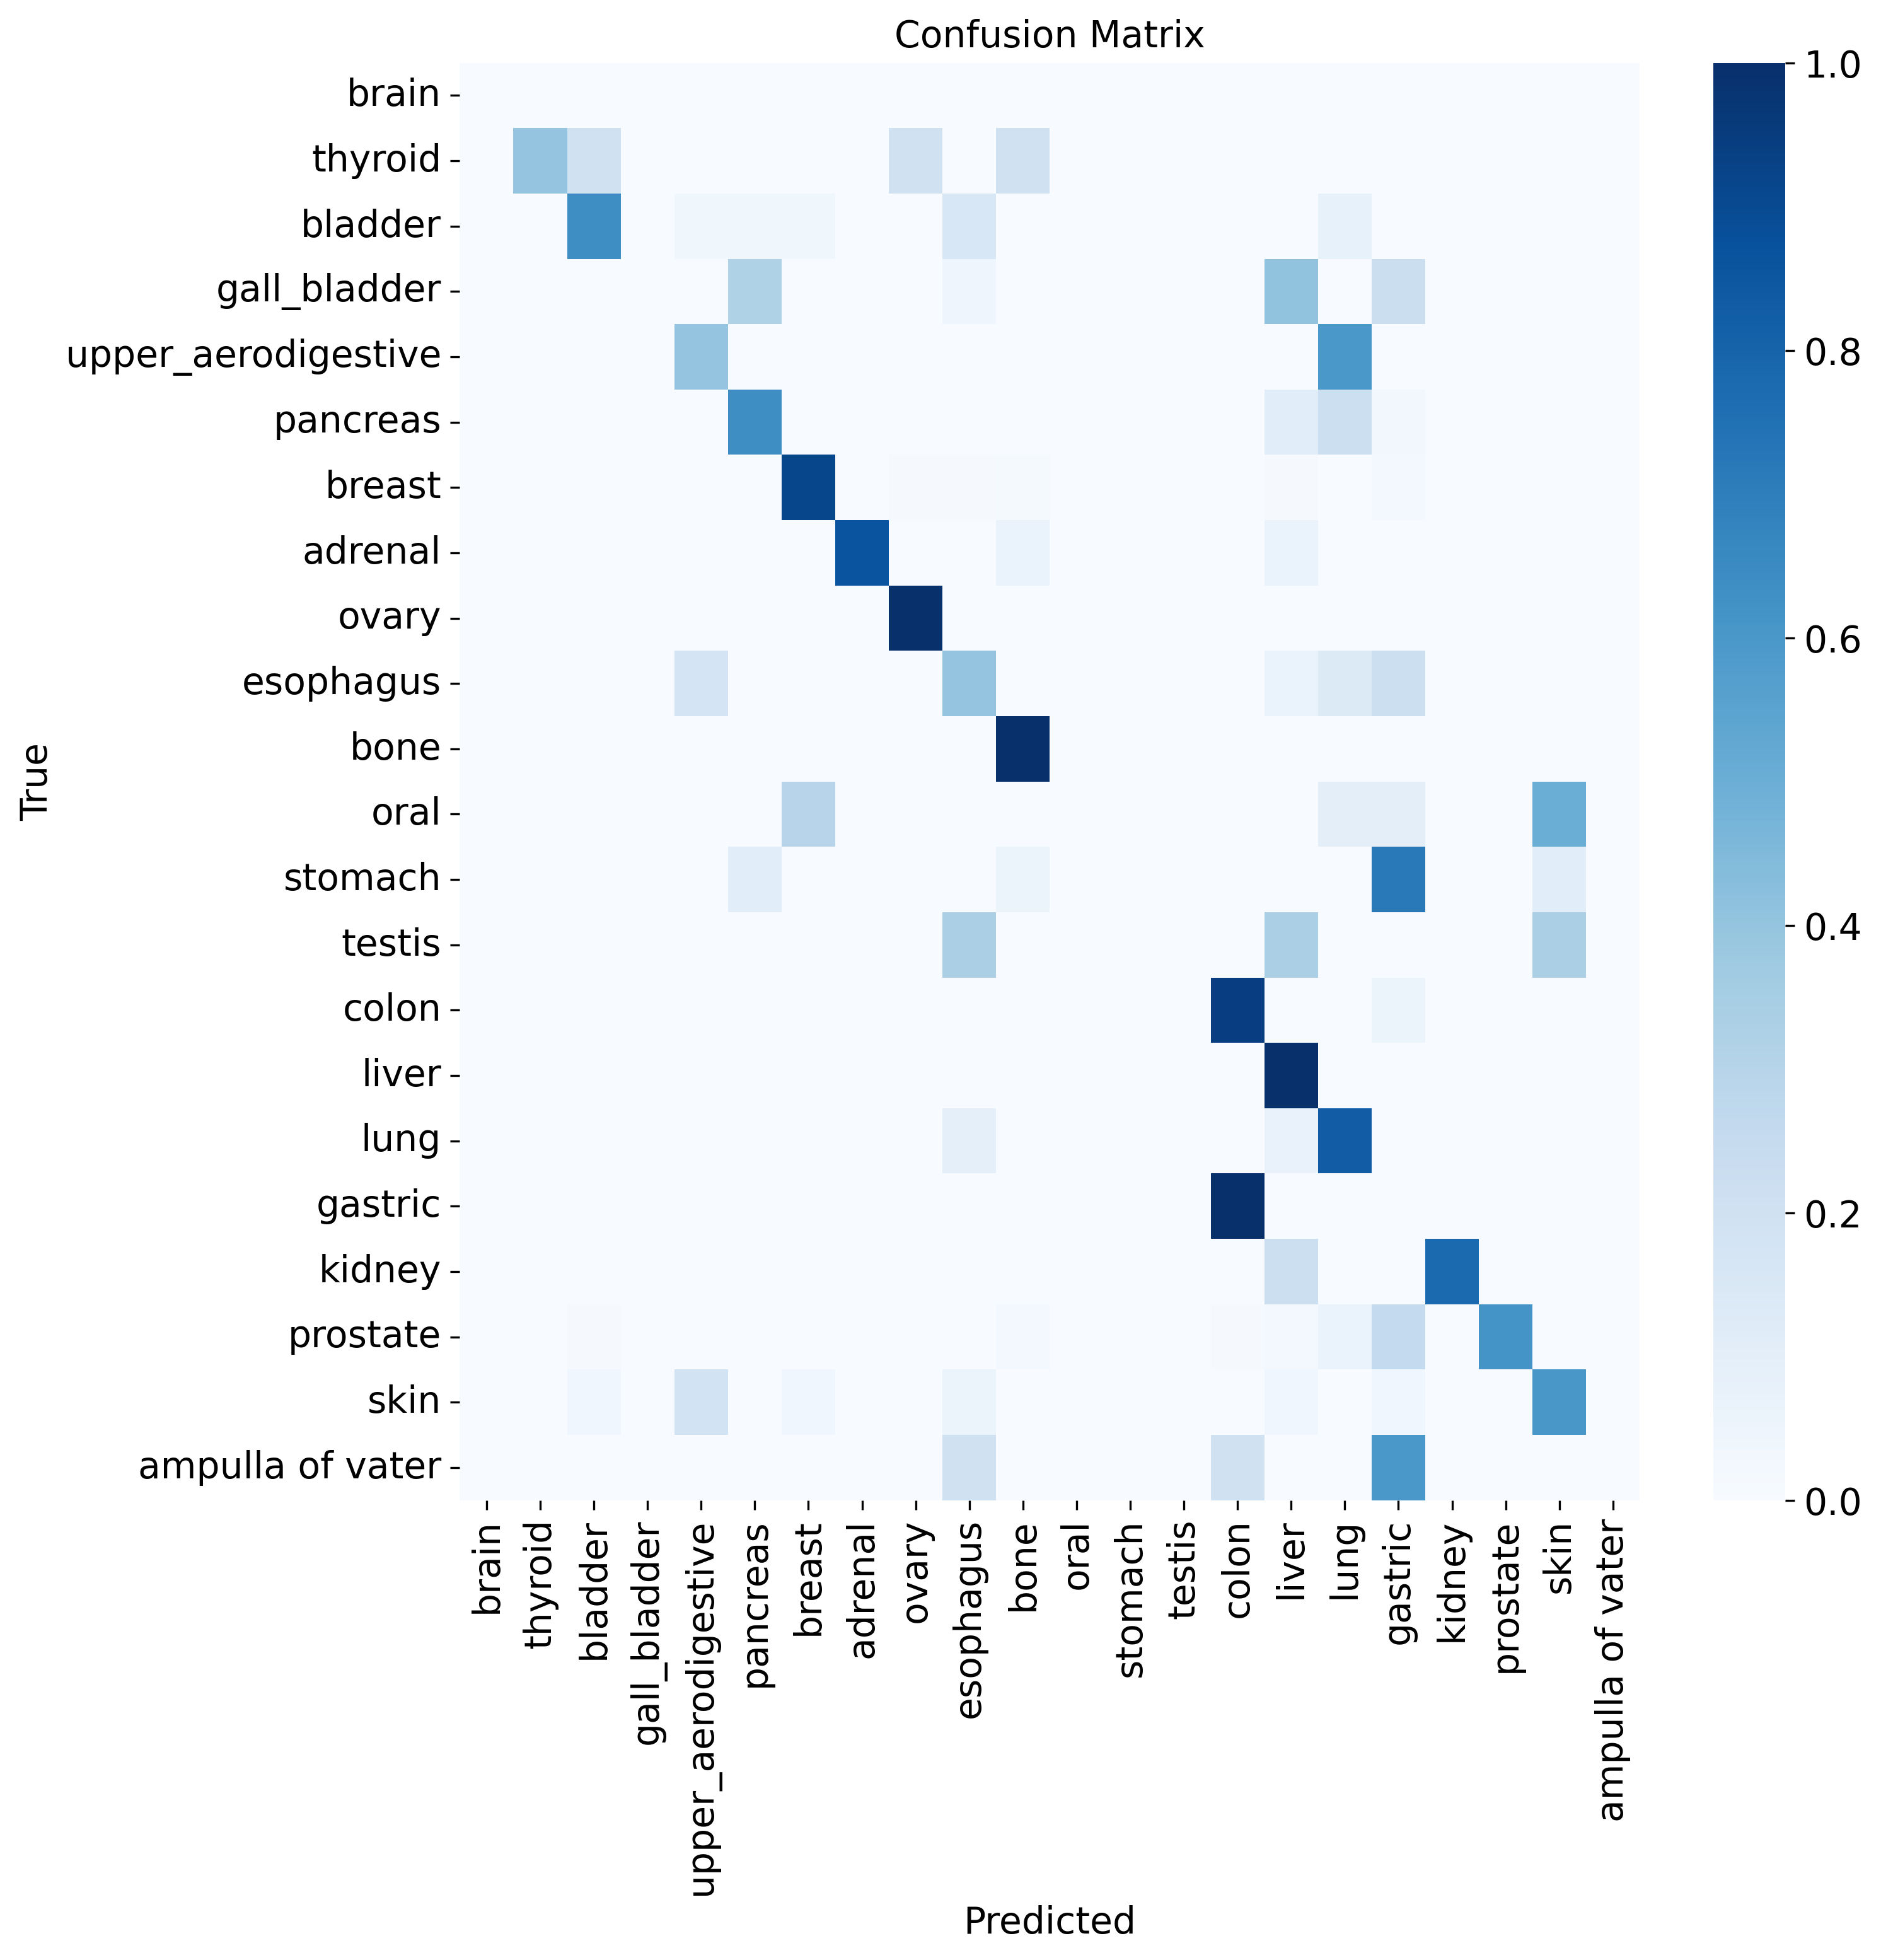

In [140]:
conf = evaluator.get_confusion_matrix(of="lineage", only=['hcmi', 'met500'], on='dataset', figsize=(10,10))

In [43]:
evaluator = pl.CELLIGNER2_EVAL(cl2, additional_adata=tosend)#tosend = tosend[~tosend.obs.dataset.isin(['pediatric_PDX', 'hcmi', 'met500', 'cclf'])]

In [163]:
sc.settings.set_figure_params(dpi=800, frameon=False)
sc.set_figure_params(dpi=800)
sc.set_figure_params(figsize=(24, 24))

In [83]:
dataset.obs[dataset.obs.dataset=='hcmi'].iloc[0]

collection_site               pancreatic_head
disease_type       adenocarcinoma_ductal_type
doublingt                                   U
method                                   bulk
reference                                hg38
age                                     Adult
ends                               paired end
sequencer                 Illumina HiSeq 4000
participant_id              HCM-CSHL-0092-C25
sex                                      male
base_media                                  U
morphology                                 3D
dataset                                  hcmi
ethnicity                                   U
instability                                 U
hasebv                                      U
tissue_id                                   U
sample_type                             model
align                                    none
counter                                 HTSEQ
passage_number                              U
contamination                     

In [79]:
set(dataset.obs[dataset.obs.dataset=='hcmi'].sample_type)

{'model', 'tissue'}

In [88]:
evaluator.adata_latent.o

AnnData object with n_obs × n_vars = 14692 × 16
    obs: 'dataset', 'lineage', 'age', 'sex', 'lineage_pred', 'age_pred', 'sex_pred', 'tissue_type', 'cell_type', 'leiden'
    uns: 'neighbors', 'leiden', 'umap', 'dataset_colors', 'lineage_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [ ]:
from celligner.params import TISSUE_COLOR

In [ ]:
plot.scatter(evaluator.adata_latent.obsm.X_umap, labels={i: for i, v in evaluator.adata_latent.obs[['lineage', 'dataset', 'disease_type']].T.iterrows()} colors=TISSUE_COLOR

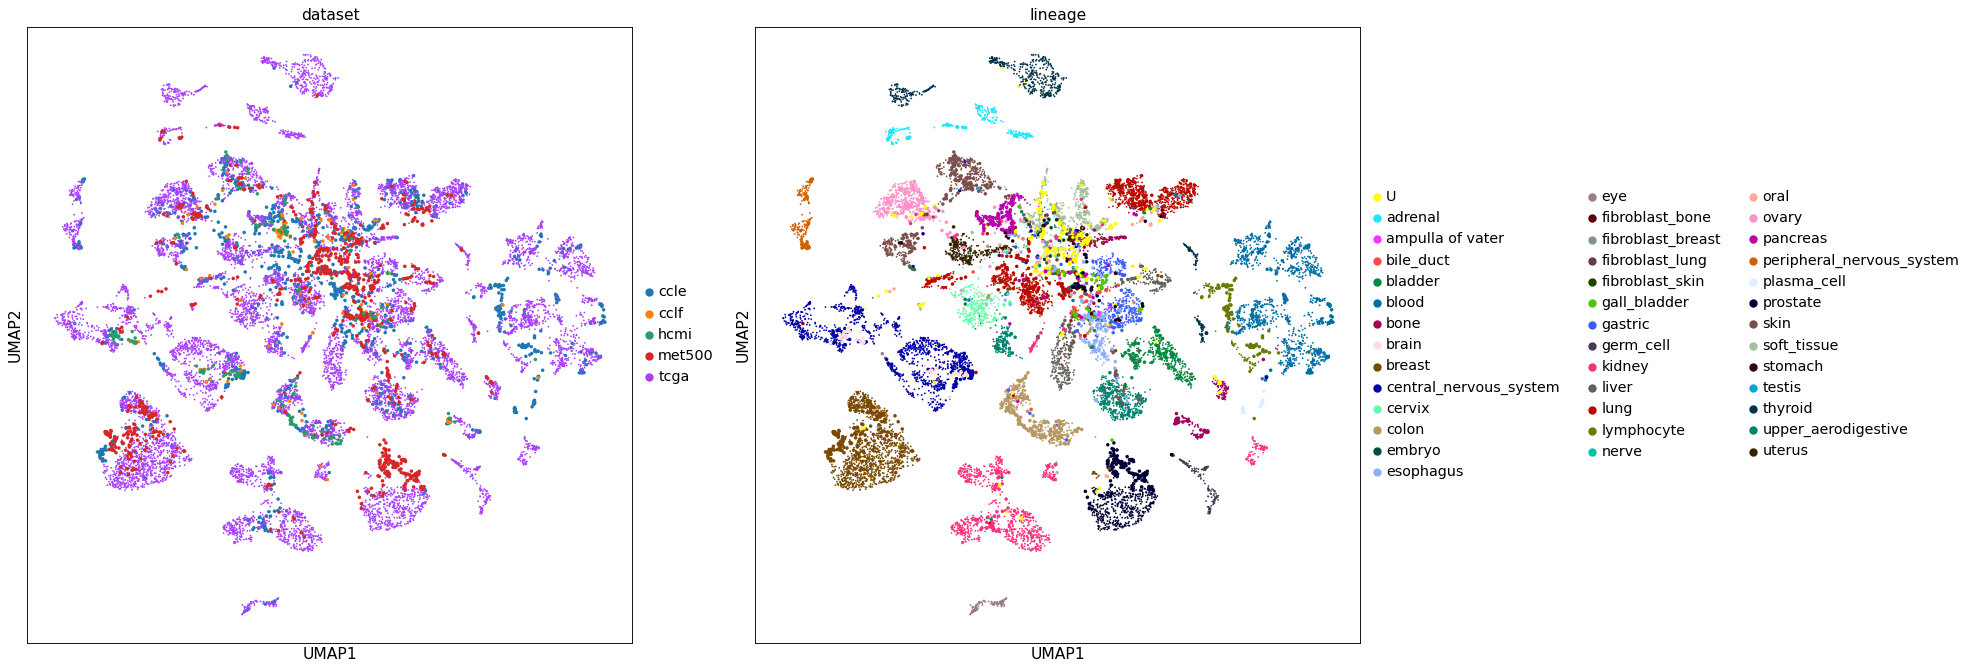

In [87]:
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=.4,
                            alpha=1,
                            spread=1,
                            random_state=None),
                    color=['dataset','lineage'],
                    projection="2d",
                    n_neighbors = 7,
                    #palette='tab20',
                    add_outline = False,
                    size = [40 if val != 'tcga' else 10 for val in evaluator.adata_latent.obs['dataset']])

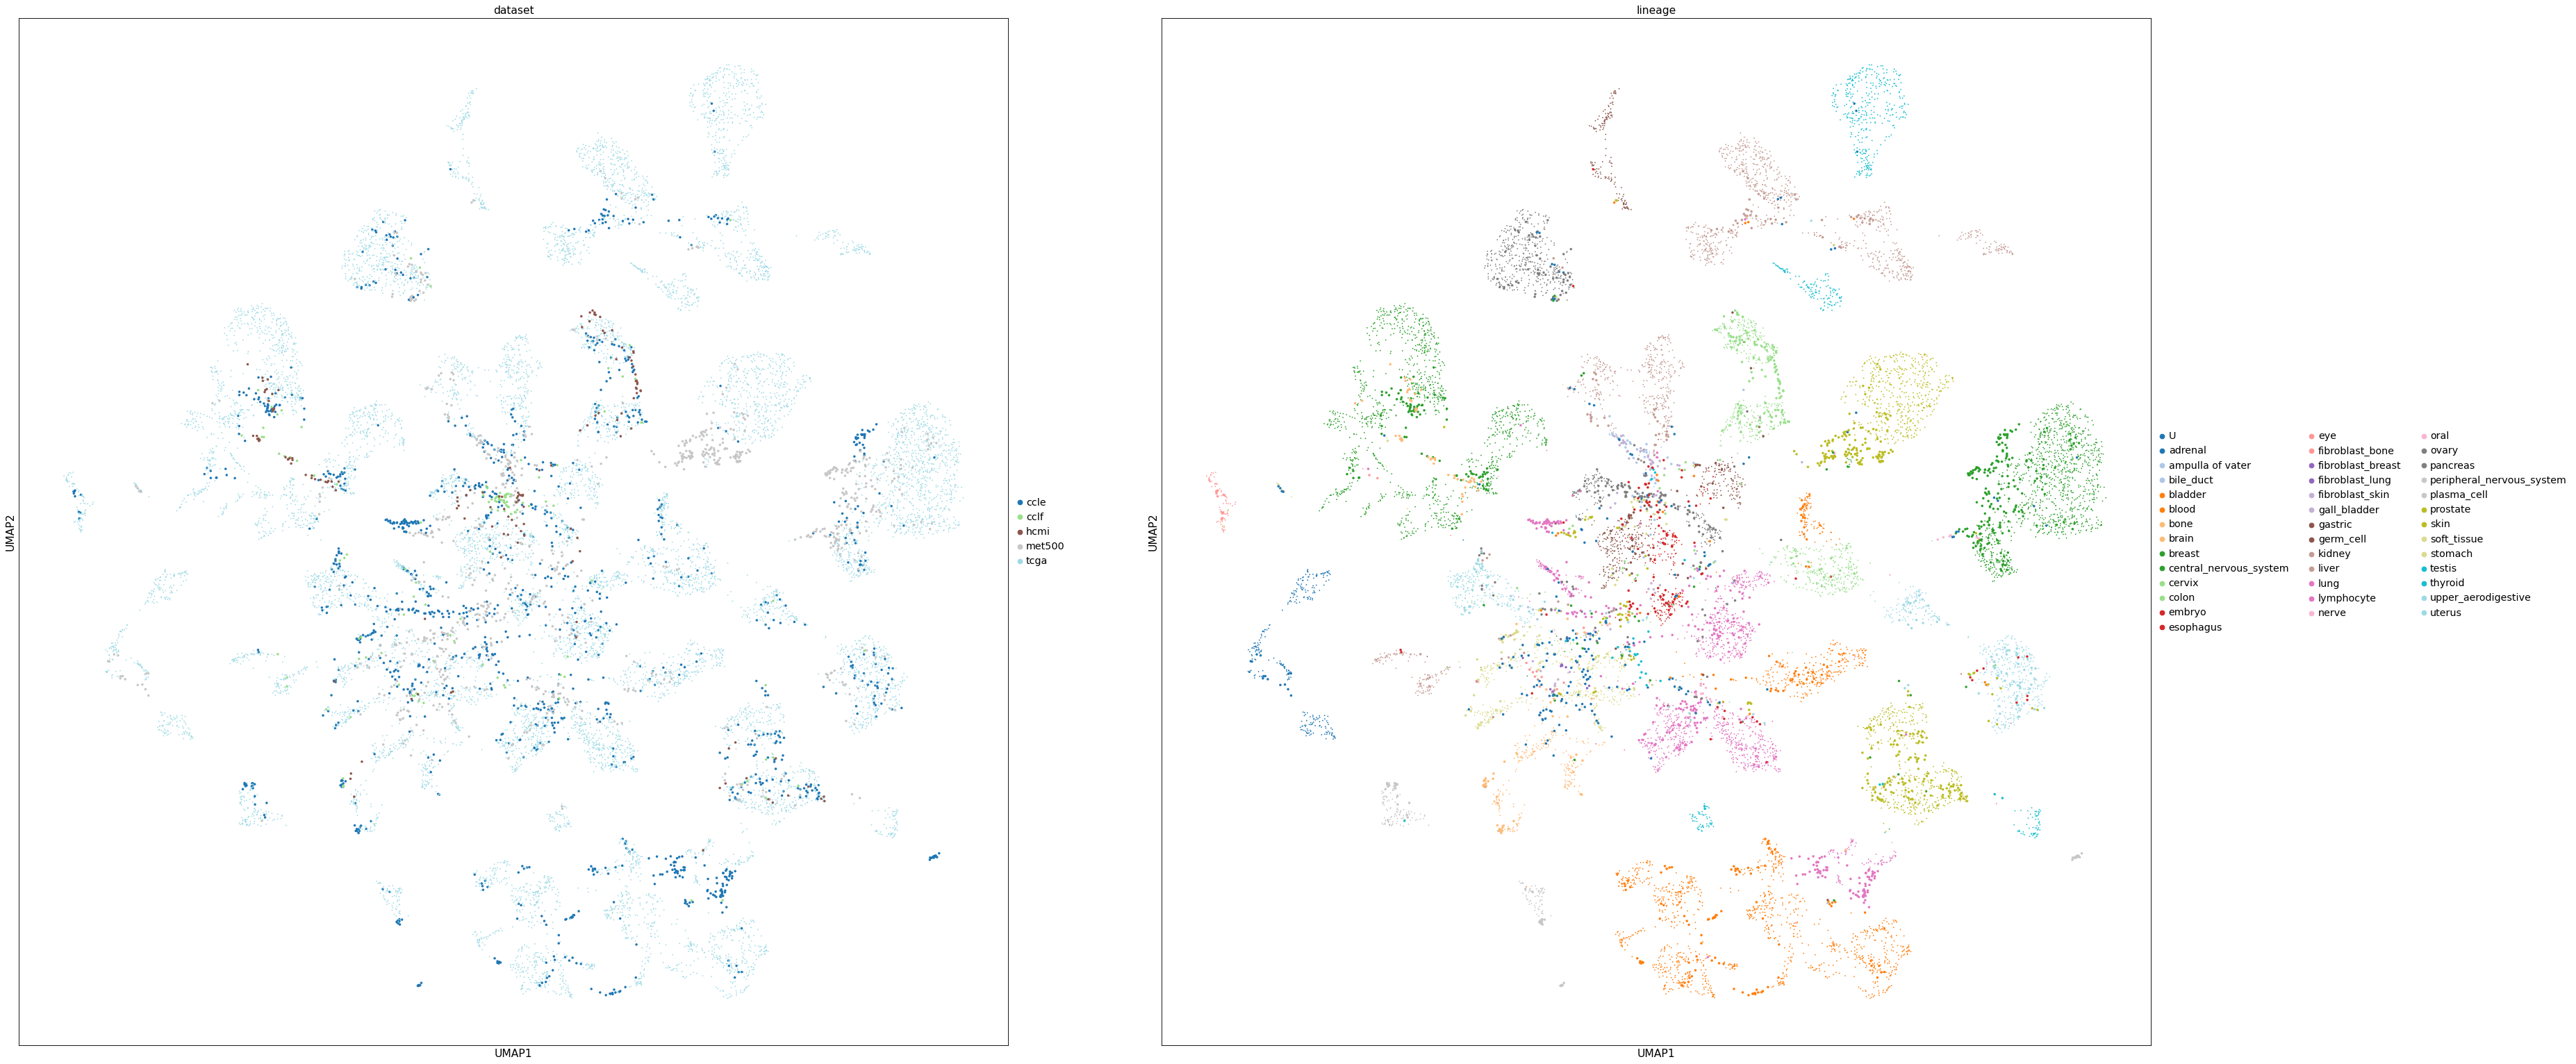

In [165]:
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=.4,
                            alpha=1,
                            spread=1,
                            random_state=None),
                    color=['dataset','lineage'],
                    projection="2d",
                    n_neighbors = 7,
                    rerun=False,
                    #palette='tab20',
                    add_outline = False,
                    size = [40 if val != 'tcga' else 10 for val in evaluator.adata_latent.obs['dataset']])

In [44]:
import scib

In [45]:
adata_obs = read_h5ad('../celligner/temp/adata.h5ad.gz').obs

In [46]:
evaluator.adata_latent.obs.loc[set(adata_obs.index) & set(evaluator.adata_latent.obs.index),['tissue_type','cell_type']] = adata_obs.loc[set(adata_obs.index) & set(evaluator.adata_latent.obs.index), ['tissue_type','cell_type']]

In [48]:
dataset.obs.drop(columns=['cell_type'], inplace=True)

In [49]:
dataset.obs.loc[set(adata_obs.index) & set(evaluator.adata_latent.obs.index),['tissue_type','cell_type']] = adata_obs.loc[set(adata_obs.index) & set(evaluator.adata_latent.obs.index), ['tissue_type','cell_type']]

In [50]:
loc = ~evaluator.adata_latent.obs.cell_type.isna()

In [57]:
dataset[evaluator.adata_latent[loc].obs.index]

View of AnnData object with n_obs × n_vars = 14418 × 3000
    obs: 'collection_site', 'disease_type', 'doublingt', 'method', 'reference', 'age', 'ends', 'sequencer', 'participant_id', 'sex', 'base_media', 'morphology', 'dataset', 'ethnicity', 'instability', 'hasebv', 'tissue_id', 'sample_type', 'align', 'counter', 'passage_number', 'contamination', 'lineage', 'stage', 'conservation', 'cell_format', 'tissue_type', 'cell_type'

In [58]:
evaluator.adata_latent[loc]

View of AnnData object with n_obs × n_vars = 14418 × 16
    obs: 'dataset', 'lineage', 'age', 'sex', 'lineage_pred', 'age_pred', 'sex_pred', 'tissue_type', 'cell_type'

In [60]:
evaluator.adata_latent.obsm

AxisArrays with keys: 

In [59]:
dataset.obsm.obs

AxisArrays with keys: 

In [65]:
dataset.obs.cell_type = dataset.obs.cell_type.astype('category')
dataset.obs.tissue_type = dataset.obs.tissue_type.astype('category')
evaluator.adata_latent.obs.cell_type = evaluator.adata_latent.obs.cell_type.astype('category')
evaluator.adata_latent.obs.tissue_type = evaluator.adata_latent.obs.tissue_type.astype('category')

In [71]:
evaluator.adata_latent.obsm['X_pca'] = evaluator.adata_latent.X

ValueError: Value passed for key 'X_pca' is of incorrect shape. Values of obsm must match dimensions (0,) of parent. Value had shape (14418, 16) while it should have had (14692,).

In [72]:
scib.metrics.metrics(dataset[evaluator.adata_latent[loc].obs.index], evaluator.adata_latent[loc], batch_key="cell_type", label_key='tissue_type', cell_cycle_=False, organism='human', trajectory_=False, isolated_labels_asw_=True, silhouette_=True, hvg_score_=False, graph_conn_=True, pcr_=True, isolated_labels_f1_=False, nmi_=True, ari_=True, kBET_=True, ilisi_=True, clisi_=True,)

NMI...
ARI...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
kBET...
cLISI score...
/tmp/lisi_f_sfja7t/input.mtx /tmp/lisi_f_sfja7t/
iLISI score...
/tmp/lisi_90rg02kf/input.mtx /tmp/lisi_90rg02kf/


,0
NMI_cluster/label,0.831564
ARI_cluster/label,0.701115
ASW_label,0.560188
ASW_label/batch,0.845711
PCR_batch,0.926795
cell_cycle_conservation,NaN
isolated_label_F1,NaN
isolated_label_silhouette,0.482754
graph_conn,0.834280
kBET,NaN


### making expimap mode

In [15]:
cl2 = celligner2.CELLIGNER2.load_query_data(adata=dataset[dataset.obs.dataset.isin(['hcmi', 'met500', 'cclf'])].copy(), reference_model='temp/subdataset_learning_target')

AnnData object with n_obs × n_vars = 1141 × 3000
    obs: 'collection_site', 'disease_type', 'doublingt', 'method', 'reference', 'age', 'cell_type', 'ends', 'sequencer', 'participant_id', 'sex', 'base_media', 'morphology', 'dataset', 'ethnicity', 'instability', 'hasebv', 'tissue_id', 'sample_type', 'align', 'counter', 'passage_number', 'contamination', 'lineage', 'stage', 'conservation', 'cell_format'
dict_keys(['apply_log_', 'beta_', 'betaclass_', 'classifier_hidden_layer_sizes_', 'condition_keys_', 'conditions_', 'dr_rate_', 'hidden_layer_sizes_', 'input_dim_', 'is_trained_', 'latent_dim_', 'miss_', 'mmd_boundary_', 'mmd_on_', 'predictor_keys_', 'predictors_', 'recon_loss_', 'use_bn_', 'use_ln_', 'use_mmd_', 'use_own_kl_'])
> /home/jeremie/celligner2/celligner2/othermodels/base/_base.py(266)load_query_data()
    264 
    265                 pdb.set_trace()
--> 266                 if len(new) > 0:
    267                     print("Adding new conditions: ", new)
    268               

In [16]:
cl2.train(
    n_epochs=300,
    alpha_epoch_anneal=200,
    early_stopping_kwargs={
        "early_stopping_metric": "val_unweighted_loss",
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    weight_decay=0
)

using leiden clustering to define training group mixing


         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
/home/jeremie/celligner2/celligner2/dataset/celligner2/anndata.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.goodloc = torch.tensor(goodloc, dtype=torch.bool)


Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
 |████████------------| 40.7%  - val_loss: 6397.3243815104 - val_recon_loss: 4888.5161132812 - val_kl_loss: 65.8318252563 - val_class_ce_loss: 189.6838480632 - val_mmd_loss: 1319.0844726562
ADJUSTED LR
 |██████████----------| 50.0%  - val_loss: 6394.7420247396 - val_recon_loss: 4889.6235351562 - val_kl_loss: 65.8328857422 - val_class_ce_loss: 185.9765192668 - val_mmd_loss: 1319.0930582682
ADJUSTED LR
 |██████████----------| 52.3%  - val_loss: 6382.3631184896 - val_recon_loss: 4894.4920247396 - val_kl_loss: 65.8312606812 - val_class_ce_loss: 185.7355957031 - val_mmd_loss: 1302.0842692057
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping cr

In [ ]:
evaluator = pl.CELLIGNER2_EVAL(cl2)

In [ ]:
cl2.train(
    n_epochs=300,
    alpha_epoch_anneal=200,
    early_stopping_kwargs={
        "early_stopping_metric": "val_unweighted_loss",
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    weight_decay=0
)